# Import libraries

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator
from typing import Callable, List

# Some usefull functions

In [50]:
def linear(x: np.ndarray) -> np.ndarray:
    return x


def relu(x: np.ndarray) -> np.ndarray:
    x[x < 0] = 0
    return x


def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))


def gaussian(x: np.ndarray) -> np.ndarray:
    return np.exp((-1) * x * x)


def tanh(x: np.ndarray) -> np.ndarray:
    return np.tanh(x)


def softplus(x: np.ndarray) -> np.ndarray:
    return np.log(1 + np.exp(x))


def softsigh(x: np.ndarray) -> np.ndarray:
    return x / (1 + np.abs(x))


def MSE(y: np.ndarray, sigma: np.ndarray) -> np.ndarray:
    return (y - sigma)*(y - sigma)

# Definition of class Layer

In [51]:
class Layer:
    def __init__(self,
                 input_size: int,
                 output_size: int,
                 activation: Callable[[np.ndarray], np.ndarray],
                 weights = None,
                 learning_rate: float = 0.01) -> None:
        self.input = input_size + 1
        self.output = output_size
        self.activation_function = activation
        self.learning_rate = learning_rate
        self.h = np.array([0 for i in range(output_size)])
        self.h_no_bias = None

        if weights is not None:
            self.weights = weights
        else:
            np.random.seed(41)
            self.weights = np.random.uniform(-0.5, 0.5,
                                             (self.output, self.input)) #+ 0.5

    def update(self, gradient: np.ndarray) -> None:
#         print("weights: ", self.weights)
        self.weights -= self.learning_rate * gradient
#         print("Updated weights: ", self.weights)

    def predict(self, x: np.ndarray) -> np.ndarray:
        x_extended = np.vstack([np.ones((1, x.shape[1]), dtype=x.dtype), x])
        self.h_no_bias = self.weights@x_extended
#         print("In prediction: ", self.weights.shape, x_extended.shape)
        #         print("weights: ", self.weights)
        #         print("x: ", x_extended)
        self.h = self.weights @ x_extended
        return self.activation_function(self.h)

    def repeat_predict(self) -> np.ndarray:
        #         print("h: ", self.h.shape, self.h)
        return self.activation_function(self.h)

    def deriv(self, delta: float = 1e-10) -> np.ndarray:
        if self.activation_function is linear:
            return np.ones(self.h.shape)
        elif self.activation_function is sigmoid:
            f = sigmoid(self.h)
            return np.multiply(f,  (1 - f))
        elif self.activation_function is tanh:
            f = tanh(self.h)
            return 1 - f**2
        elif self.activation_function is gaussian:
            return -2 * np.multiply(self.h, gaussian(self.h))
        elif self.activation_function is softplus:
            return sigmoid(self.h)
        else:
            return self.h
#         func_delta = self.activation_function(self.h + delta)
#         func = self.activation_function(self.h)
#         deriv = (func_delta - func) / delta
#         print("Derivative: ", deriv.shape, deriv)
#         return deriv

# Definition of class Neural Network (NN)

In [52]:
class NeuralNet:
    def __init__(self,
                 layers: List,
                 loss_function: Callable[[np.ndarray, np.ndarray], np.ndarray],
                 learning_rate: float = 0.01) -> None:
        self.loss = loss_function
        self.layers = []
        for layer in layers:
            self.layers.append(
                Layer(layer[0],
                      layer[1],
                      layer[2],
#                       weights=layer[3],
                      learning_rate=learning_rate))

    def predict(self, x: np.ndarray, new: bool = False) -> np.ndarray:
        if new:
            x = x.T
        y_input = x
        y_output = x
        for layer in self.layers:
            y_output = layer.predict(y_input)
#             print(y_output)
            y_input = y_output
        return y_output

    def update(self, x: np.ndarray, gradient_0: np.ndarray) -> None:
        delta = np.multiply(gradient_0, self.layers[-1].deriv())
#         print("Derivative: ", self.layers[-1].deriv())
#         print("DELTA: ", delta)
        y = self.layers[-2].repeat_predict()
#         print("Y: ", y)
        y = np.vstack([np.ones((1, y.shape[1]), dtype=y.dtype), y])
#         print("Y: ", y)
        gradient = delta @ y.T
        #         self.layers[-1].update(gradient)
        gradients = [gradient]
#         prev_gradient = np.zeros(gradient.shape, dtype=gradient.dtype)
        for i in range(len(self.layers) - 2, -1, -1):
#             print("Gradient ", i + 1, ": ", prev_gradient.shape, prev_gradient)
#             print("Gradient ", i + 1, ": ", gradient.shape, gradient)
#             print(i)
#             print("Weights before: ", i, self.layers[i + 1].weights.T)
            weights = np.delete(self.layers[i + 1].weights, 0, 1)
#             print("Weights: ", i+1, weights)
            delta = weights.T @ delta
#             print("DELTA: ", delta)
            deriv = self.layers[i].deriv()
#             print("Derivative: ", deriv)
            delta = np.multiply(delta, deriv)
#             print("DELTA: ", delta)
            if i != 0:
                y = self.layers[i - 1].repeat_predict()
            else:
                y = x
            y_prev = np.vstack([np.ones((1, y.shape[1]), dtype=y.dtype), y])
            gradient = delta @ y_prev.T
            gradients.append(gradient)
#             self.layers[i + 1].update(prev_gradient)
#         print("Gradient ", 0, ": ", gradient.shape, gradient)
#         self.layers[0].update(gradient)
        for i in range(len(self.layers)):
            self.layers[i].update(gradients[-i-1])
#         print("Average grad per layer: ")
#         for gradient in gradients:
#             print((gradient))

    def grad(self,
             y_predict: np.ndarray,
             y_true: np.ndarray,
             delta: float = 1e-10) -> np.ndarray:
        return 2*(y_predict - y_true)
#         return (self.loss((y_predict + delta), y_true) -
#                 self.loss(y_predict, y_true)) / delta

    def fit(self, x: np.ndarray, y_true: np.ndarray, epoch: int = 0):
        x = x.T
        y_true = y_true.T
        loss = []
        grad_loss = []
        abs_grad_loss = []
        if (epoch > 0):
            while epoch > 0:
                print("new epoch")
                y_predict = self.predict(x)
                gradient = self.grad(y_predict, y_true)
#                 gradient = self.loss(y_predict, y_true)
#                 print("Y_predicted: ", y_predict.shape, y_predict)
#                 print("Gradient_START: ", gradient.shape, gradient)
                print("Average loss", (self.loss(y_predict, y_true)))
                loss.append(np.mean(self.loss(y_predict, y_true)))
                print("Average loss gradient", (gradient))
                grad_loss.append(np.mean(gradient))
                abs_grad_loss.append(np.mean(np.abs(gradient)))
                print("Average absolute loss gradient", np.mean(np.abs(gradient)))
                self.update(x, gradient)
                epoch -= 1
        else:
            y_predict = self.predict(x)
            gradient = self.grad(y_predict, y_true)
            while np.abs(gradient).sum() > 10:
                print("new epoch")
                self.update(x, gradient)
                y_predict = self.predict(x)
                gradient = self.grad(y_predict, y_true)
        return loss, grad_loss, abs_grad_loss

In [53]:
x = np.reshape(np.array([2, 3]), (2, 1))

y = np.reshape(np.array([1, 0.2]), (2, 1))

In [54]:
nn = NeuralNet([(2, 2, sigmoid, np.array([[0.25, 0.3, -0.4], [0.45, 0.2, 0.6]])),
               (2, 2, sigmoid, np.array([[0.15, 0.7, 0.5], [0.35, -0.3, -0.1]]))], MSE, learning_rate=0.1)

In [55]:
nn.predict(x)

array([[0.41180488],
       [0.36346131]])

In [56]:
nn.fit(x.T, y.T, epoch=1000)

new epoch
Average loss [[0.3459735]
 [0.0267196]]
Average loss gradient [[-1.17639024]
 [ 0.32692262]]
Average absolute loss gradient 0.7516564298957599
new epoch
Average loss [[0.33520953]
 [0.02626304]]
Average loss gradient [[-1.15794564]
 [ 0.32411754]]
Average absolute loss gradient 0.7410315896445243
new epoch
Average loss [[0.32472671]
 [0.02581009]]
Average loss gradient [[-1.13969594]
 [ 0.32131037]]
Average absolute loss gradient 0.7305031525167172
new epoch
Average loss [[0.31452677]
 [0.02536071]]
Average loss gradient [[-1.12165373]
 [ 0.31850094]]
Average absolute loss gradient 0.7200773339336404
new epoch
Average loss [[0.30461031]
 [0.02491496]]
Average loss gradient [[-1.10383026]
 [ 0.31568944]]
Average absolute loss gradient 0.7097598518682846
new epoch
Average loss [[0.29497691]
 [0.0244729 ]]
Average loss gradient [[-1.08623554]
 [ 0.31287631]]
Average absolute loss gradient 0.6995559280193782
new epoch
Average loss [[0.28562525]
 [0.02403464]]
Average loss gradien

([0.1863465493194549,
  0.18073628548526474,
  0.17526839793572885,
  0.16994374151286995,
  0.16476263357187387,
  0.1597249049756249,
  0.15482994687608925,
  0.15007675400707807,
  0.14546396509420745,
  0.14098990085149365,
  0.13665259990061826,
  0.1324498528309923,
  0.12837923452265682,
  0.12443813478170036,
  0.12062378728829831,
  0.11693329682799924,
  0.11336366476399906,
  0.10991181270810686,
  0.10657460435734036,
  0.10334886547841879,
  0.10023140204116393,
  0.09721901652184588,
  0.09430852241720249,
  0.09149675702805678,
  0.08878059258740263,
  0.08615694582108108,
  0.08362278603954701,
  0.08117514186672285,
  0.07881110671669964,
  0.07652784313129399,
  0.0743225860914879,
  0.07219264541387249,
  0.07013540733970303,
  0.06814833541935511,
  0.06622897078914158,
  0.0643749319308775,
  0.06258391399749669,
  0.060853687780656196,
  0.05918209838878348,
  0.05756706369659914,
  0.05600657261990189,
  0.05449868326245699,
  0.05304152097525509,
  0.05163327636

In [57]:
nn.predict(x)

array([[0.96198045],
       [0.19972057]])

# Generate some data

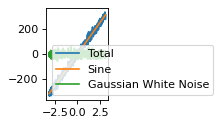

In [58]:
x_train = np.linspace(-np.pi, np.pi, num=500, dtype=np.float64)
n = np.random.normal(scale=20, size=x_train.size)
# y_true = x_train**2
# y_true = 200 * np.sin(x_train)
y_true = 100 * x_train
y_train = y_true + n

x_train = np.reshape(x_train, (500, 1))
y_train = np.reshape(y_train, (500, 1))

plt.figure(figsize=(1, 1.5), dpi=80)
plt.plot(x_train, y_train, label='Total')
plt.plot(x_train, y_true, label='Sine')
plt.plot(x_train, n, label='Gaussian White Noise')

plt.legend()
plt.show()

# Check the algorithms

In [59]:
nn = NeuralNet([(1, 3, gaussian), (3, 3, gaussian), (3, 1, linear)], MSE, learning_rate=0.01)

In [60]:
out_y = nn.predict(x_train, new=True)

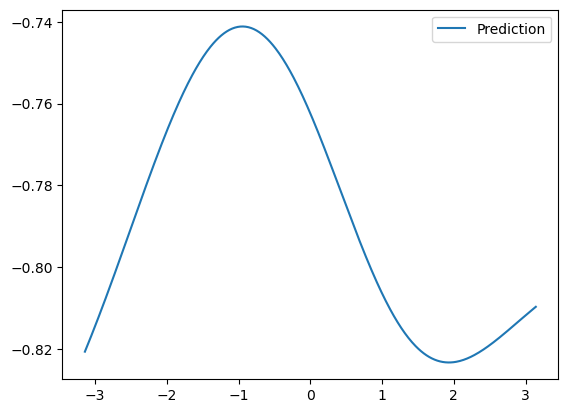

In [61]:
# plt.figure(figsize=(1, 1.5), dpi=80)
# plt.plot(x_train, y_train, label='Expected')
plt.plot(x_train, out_y.T, label='Prediction')

plt.legend()
plt.show()

In [62]:
# for x, y in zip(x_train, y_train):
#     x = np.reshape(x, (1, 1))
#     y = np.reshape(y, (1, 1))
#     nn.fit(x, y, epoch=10)

In [63]:
loss, grad_loss, abs_grad_loss = nn.fit(x_train, y_train, epoch=10)

new epoch
Average loss [[9.12014554e+04 1.10811523e+05 9.85300390e+04 8.62983352e+04
  1.10774829e+05 1.06279746e+05 1.00603205e+05 1.05022277e+05
  1.01558498e+05 9.16184744e+04 1.03304263e+05 7.65327236e+04
  9.63674087e+04 7.16036228e+04 7.06840397e+04 7.85777297e+04
  1.09144950e+05 1.01987631e+05 8.83790271e+04 1.02228043e+05
  6.97834818e+04 1.04562113e+05 7.85467979e+04 8.60364071e+04
  6.80407993e+04 9.57841093e+04 6.77597244e+04 7.55564257e+04
  8.46748231e+04 6.94897998e+04 6.23610607e+04 8.53977631e+04
  8.09006424e+04 9.86198600e+04 8.23192043e+04 8.32531445e+04
  7.05114720e+04 7.00138386e+04 7.52399098e+04 7.75765022e+04
  5.96884620e+04 6.78936994e+04 5.21138055e+04 5.85746965e+04
  7.70982745e+04 7.61045505e+04 6.07437437e+04 7.45483024e+04
  6.23747513e+04 5.94908787e+04 5.84013658e+04 5.79785608e+04
  6.89257473e+04 7.57353491e+04 8.15449227e+04 6.18947860e+04
  4.27580737e+04 7.87218709e+04 4.53627007e+04 7.63187508e+04
  6.89084420e+04 6.08697807e+04 4.29171944e+04 

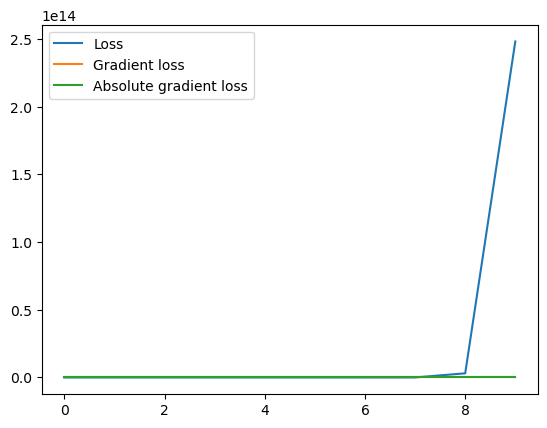

In [64]:
# plt.figure()
x = [i for i in range(10)]
plt.plot(x, loss, label='Loss')
plt.plot(x, grad_loss, label='Gradient loss')
plt.plot(x, abs_grad_loss, label='Absolute gradient loss')

plt.legend()
plt.show()

In [65]:
# plt.Figure()
# x = [i for i in range(10)]
# plt.plot(x, loss, label='Loss')
# plt.plot(x, grad_loss, label='Gradient loss')
# plt.plot(x, abs_grad_loss, label='Absolute gradient loss')

# plt.legend()
# plt.show()

In [66]:
for layer in nn.layers:
    print(layer.weights)

[[ 166.82789487  -67.57883952]
 [-115.30447312  -36.05846802]
 [ -57.24222153  293.41792882]]
[[ -7.11949483  88.95239386 -73.67814198 -89.1005259 ]
 [ 10.11512132 -20.17610962  24.07983279  30.51977029]
 [-48.08895461 -45.87369718   1.28798792 -11.89002381]]
[[ 1.41745924e+08  3.67724304e+01 -2.85984602e+01  1.46169086e+01]]


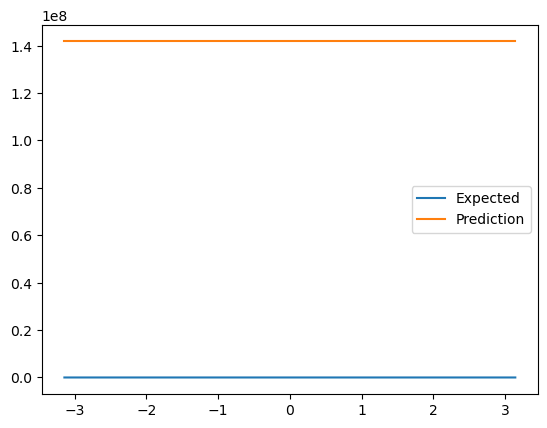

In [67]:
out_y = nn.predict(x_train, new=True).T

# plt.figure(figsize=(1, 1.5), dpi=80)
plt.plot(x_train, y_train, label='Expected')
plt.plot(x_train, out_y, label='Prediction')

plt.legend()
plt.show()

In [68]:
# y_train

In [69]:
# (MSE(y_train.T + 1e-5, y_true.T) - MSE(y_train.T, y_true.T)) / 1e-5

In [70]:
check = Layer(1, 1, sigmoid)

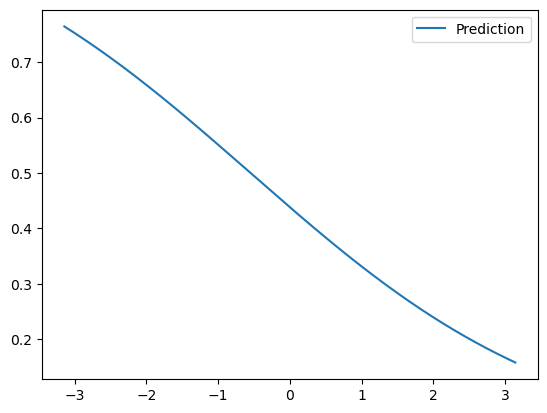

In [71]:
# plt.figure(figsize=(1, 1.5), dpi=80)
# plt.plot(x_train, y_train, label='Expected')
plt.plot(x_train, check.predict(x_train.T).T, label='Prediction')

plt.legend()
plt.show()

In [72]:
import numpy as np

class NeuralNetwork:
    
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # initialize weights and biases randomly
        self.W1 = np.random.randn(self.input_size, self.hidden_size)
        self.b1 = np.random.randn(self.hidden_size)
        self.W2 = np.random.randn(self.hidden_size, self.output_size)
        self.b2 = np.random.randn(self.output_size)
        
    def forward(self, X):
        # calculate hidden layer activation
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)
        
        # calculate output layer activation
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        y_hat = self.sigmoid(self.z2)
        
        return y_hat
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def sigmoid_prime(self, z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))
    
    def backward(self, X, y, y_hat, learning_rate):
        # calculate error and delta for output layer
        error = y - y_hat
        delta2 = error * self.sigmoid_prime(self.z2)
        
        # calculate error and delta for hidden layer
        error1 = np.dot(delta2, self.W2.T)
        delta1 = error1 * self.sigmoid_prime(self.z1)
        
        # update weights and biases
        self.W2 += learning_rate * np.dot(self.a1.T, delta2)
        self.b2 += learning_rate * np.sum(delta2, axis=0)
        self.W1 += learning_rate * np.dot(X.T, delta1)
        self.b1 += learning_rate * np.sum(delta1, axis=0)
    
    def train(self, X, y, learning_rate, epochs):
        for i in range(epochs):
            y_hat = self.forward(X)
            self.backward(X, y, y_hat, learning_rate)
            
            # print loss every 100 epochs
            if i % 100 == 0:
                loss = np.mean(np.square(y - y_hat))
                print(f"Epoch {i}: Loss = {loss:.4f}")
                
# example usage
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[0], [1], [1], [0]])

nn = NeuralNetwork(input_size=2, hidden_size=3, output_size=1)
nn.train(X, y, learning_rate=0.01, epochs=1000)

# test prediction on new input
new_X = np.array([[0.5, 0.5]])
prediction = nn.forward(new_X)
print(f"Prediction: {prediction}")

Epoch 0: Loss = 0.3681
Epoch 100: Loss = 0.3368
Epoch 200: Loss = 0.3056
Epoch 300: Loss = 0.2810
Epoch 400: Loss = 0.2655
Epoch 500: Loss = 0.2573
Epoch 600: Loss = 0.2534
Epoch 700: Loss = 0.2515
Epoch 800: Loss = 0.2507
Epoch 900: Loss = 0.2503
Prediction: [[0.49505133]]
